Lorenzo Olmo Marchal
A17013640
MED 277 Lab 1

# Imports

In [117]:
import re
import os
import nltk
from nltk import word_tokenize
import pandas as pd
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/Reginald/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/Reginald/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

# PART 1: Discharge Summaries

### Uploading

In [90]:
"""
Dataset consists of 20 discharge summaries from Kaggle. 
"""
directory = "./dataset_for_lab1"
discharge_paths = []
for item in os.listdir(directory):
    if "discharge" in item.lower():
        discharge_paths.append(os.path.join(directory, item))

### Extracting Information

- | is the logical or
- .* will match any character (like spaces) between the first and second word
- \S* will match any non-white space character

In [83]:
def find_dcdx_section(fname):
    # this translates to any string containing discharged following any character followed by 
    #DIAGNO with a match to any non-white space character
    # or the reverse order
    start = None
    end = None
    discharge_pattern = r"((DISCHARGE.*DIAGNO\S*)|(DIAGNO\S*.*DISCHARGE))"
    # translates to new line followed by any one or more uppercase letters or spaces

    other_sections = r'((\n[A-Z\s]+:?(?=\s*\n|$))|(To be followed))'
    with open(fname, "r") as f:
        text = f.read()
        diagnosis_header = re.search(discharge_pattern, text)
        if diagnosis_header:
            start = diagnosis_header.end()
        ending_header = re.search(other_sections, text[start:])
        if ending_header:
            end = ending_header.start()
        section_name = text[diagnosis_header.start():diagnosis_header.end()+1]
        if start is not None:
            if end is not None:
                section = text[start:start+end]
            else:
                section = text[start:]
                end = len(text)
    return section, section_name, start, end


# given the discharge text get the diagnosis as a list
def find_dcdx_text(input_text, start):
    regex = r"(?:\d+\.\s+)?([A-Za-z0-9\s,\-]+(?:\sof\s[A-Za-z\s\-]+)?(?:\-[A-Za-z0-9\s\-]+)*\s?(?:\d+\syears\sago)?\.\s*)(?=\n{2}|\s*$)"
    text = []
    matches = re.finditer(regex, input_text)
    for match in matches: 
        text.append({"Text":match.group(1).strip(), "start": match.start(1) + start,"end": match.end(1) + start})
    
    return text
            
        
    

In [182]:
discharges = []

for file in discharge_paths:
    file_name = os.path.basename(file)
    section, section_name, start, end = find_dcdx_section(file)
    diagnosis = find_dcdx_text(section, start)
    for item in diagnosis:
        discharges.append({"Document": file_name, "start": item["start"], "end": item["end"], "text": item['Text']})
all_discharges = pd.DataFrame(discharges)

all_discharges.to_csv("./discharge_reports.csv", index = False, sep = "\t")

# PART 2: Radiology Reports

 ### Uploading

In [88]:
"""
Dataset consists of radiology reports. 
"""
directory = "./dataset_for_lab1"
radiology_paths = []
for item in os.listdir(directory):
    
    if "radiology" in item.lower():
        radiology_paths.append(os.path.join(directory, item))

### Extracting information

In [124]:

def find_imp_section(fname):

    start = None
    end = None
    section_name = None
    section = None

    discharge_pattern = r"(IMPRESSIONS?|FINDINGS?):?\s*"
    other_sections = r'(\n[A-Z\s]+:?(?=\s*\n|$))'

    with open(fname, "r") as f:
        text = f.read()
        diagnosis_header = re.search(discharge_pattern, text)
        if diagnosis_header:
            start = diagnosis_header.end()
        ending_header = re.search(other_sections, text[start:])
        if ending_header and start is not None:
            end = start + ending_header.start()

        if start is not None:
            section_name = text[diagnosis_header.start():diagnosis_header.end()].strip()
            if end is not None:
                section = text[start:end].strip()
            else:
                section = text[start:].strip()
                end = len(text)

    return section, section_name, start, end
# find the nouns or noun phrases (NN,NNS, NNP, NNPS tags)
def find_noun_list(input_text):
    noun_list = []
    valid_tags = ["NN", "NNS", "NNP", "NNPS"]
    text = word_tokenize(input_text)
    tags = nltk.pos_tag(text)
    for item in tags:
        if item[1] in valid_tags:
            noun_list.append({"word": item[0], "tag": item[1]})
    return noun_list



In [183]:
radiology_reports = []
for file in radiology_paths:
    file_name = os.path.basename(file)
    section, section_name, start, end = find_imp_section(file)
    if section is not None:
        noun_list = find_noun_list(section)
        for item in noun_list:
            radiology_reports.append({"Document": file_name, "noun part of speech": item["tag"], "text": item["word"]})
radiology_reports = pd.DataFrame(radiology_reports)
radiology_reports.to_csv("./radiology_reports.csv", index = False, sep = "\t")

# Calculating Precision and Recall

# 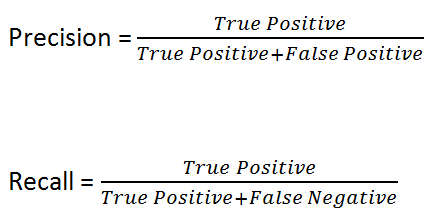

In this case, we will be defining True positives as events that match the ground truth (nouns/diagnoses present in the provided ground truth files). False positives will be marked as nouns/diagnosed included by my method not included in the ground truth. False negatives are those not included by my method included by the ground truth.  

In [179]:
def strip_text(row):
    return row.strip()

def get_matrix(gt, df):
    gt["text"] = gt["text"].apply(strip_text)
    FN = 0  
    FP = 0  
    TP = 0  
    for i, row in gt.iterrows():
        text = row["text"].strip()
        file = row["Document"]
        
        # Check if ground truth text exists in df
        if df.loc[(df["Document"] == file) & (df["text"] == text)].empty:
            #print(f"FN: {text} in {file}")
            FN += 1
        else:
            #print(f"TP: {text} in {file}")
            TP += 1

    for i, row in df.iterrows():
        text = row["text"]
        file = row["Document"]
        if gt.loc[(gt["Document"] == file) & (gt["text"] == text)].empty:
            #print(f"FP: {text} in {file}")
            FP += 1
    
    return FN, FP, TP
def recall(TP, FN):
    return (TP)/(TP+FN)
def precision(TP, FP):
    return (TP)/(TP+FP)
    


### Precision and Recall for discharge diagnoses

In [180]:
FN, FP, TP = get_matrix(gt_diagnoses, all_discharges)
recall_score = recall(TP, FN)
precision_score = precision(TP, FP)

print(f"recall: {recall_score}")
print(f"precision: {precision_score}")

recall: 0.9318181818181818
precision: 0.9425287356321839


### Precision and Recall for radiology reports

In [181]:
FN, FP, TP = get_matrix(gt_radiology, radiology_reports)
recall_score = recall(TP, FN)
precision_score = precision(TP, FP)

print(f"recall: {recall_score}")
print(f"precision: {precision_score}")

recall: 1.0
precision: 1.0
